In [ ]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

In [ ]:
# Inspect the input data

from utils import encoder_files_to_tensors, normalize_params
from utils import fast_tensor_load

from utils import sample_files
import time
import glob
import tensorflow as tf
import yaml
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl


In [ ]:
# Initialize parameters
data_dir = './tomo_data/datasets_encoder_TF_24-03-23'

# Data specific
IMG_OUTPUT_SIZE = 128
var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
num_Turns_Case = 1

# Keep only a small percentage of the entire dataset
# for faster testing.
train_cfg = {
    'normalization': 'minmax',
    'img_normalize': 'off',
    'ps_normalize': 'off',
    'dataset%': 0.01,

}


In [ ]:

ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

assert train_cfg['normalization'] == 'minmax'
assert train_cfg['img_normalize'] == 'off'

TRAINING_PATH = os.path.join(ML_dir, 'training-??.npz')
VALIDATION_PATH = os.path.join(ML_dir, 'validation-??.npz')

x_train, y_train = fast_tensor_load(
    TRAINING_PATH, train_cfg['dataset%'])
print('Number of Training files: ', len(y_train))

x_valid, y_valid = fast_tensor_load(
    VALIDATION_PATH, train_cfg['dataset%'])
print('Number of Validation files: ', len(y_valid))



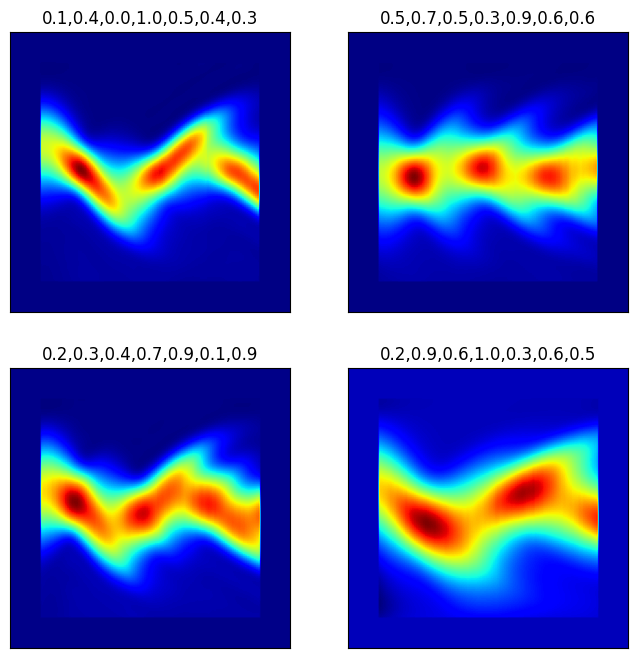

In [12]:
%matplotlib inline
# plot some of the outputs

nrows = 2
# Get nrows * nrows random images
# sample = np.random.choice(np.arange(len(x_train)),
#                           size=nrows * nrows, replace=False)

# samples_X = tf.gather(x_train, sample)
# samples_y = tf.gather(y_train, sample)

samples_X = x_train[:nrows*nrows]
samples_y = y_train[:nrows*nrows]


# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(8, 8))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    title = ','.join([f'{num:.1f}' for num in samples_y[i]])
    ax.set_title(f'{title}')


In [ ]:
fig = plt.figure()
# plt.imshow(x_valid[0])
print(x_valid.shape)
for i in range(128):
    plt.plot(x_valid[5][:][i][:])
# print(x_valid[0])
# plt.plot(x_valid[0][])

In [ ]:
eos = '/eos/user/k/kiliakis/'
simulations_dir = os.path.join(eos, 'tomo_data/results_tomo')
all_sim_dirs = os.listdir(simulations_dir)
fn = all_sim_dirs[0]
print(fn)
# paramsDict, PS_imgs, sel_turns, E_img, T_img, PS_img_dec = \
#     extract_data_Fromfolder(fn, simulations_dir, IMG_OUTPUT_SIZE, zeropad,
#                             start_turn, skipturns, version=4)


In [ ]:
from utils import read_pk
turn_num, T_img, PS, fn, params_dict = read_pk(file_name)
print(np.array2string(T_img, threshold=100000, separator=',', precision=2, max_line_width=10000))
# print(T_img.dtype)
# print(np.max(T_img))


In [ ]:
import pickle as pk
raw = tf.io.read_file(file_name)
image = tf.io.decode_raw(raw, tf.uint8)
print(image)
data = pk.loads(image)
print(type(T_img))
x_train, y_train = encoder_files_to_tensors(file_names, normalize='minmax')
print(x_train.dtype)

In [ ]:
import re
import h5py as hp

IMG_OUTPUT_SIZE = 128
zeropad = 14
skipturns = 3
start_turn = 1

pattern_string = 'phEr(?P<phEr>.+)_enEr(?P<enEr>.+)_bl(?P<bl>.+)_int(?P<int>.+)_Vrf(?P<Vrf>.+)_mu(?P<mu>.+)_VrfSPS(?P<VrfSPS>.+)'
paramsDict = {k: float(v) for k, v in re.match(
    pattern_string, fn).groupdict().items()}
E_img = np.zeros((IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE))
T_img = np.zeros((IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE))
sf = hp.File(os.path.join(os.path.join(
    simulations_dir, fn), 'saved_result.hdf5'), 'r')

BunchProfiles = np.array(sf['bunchProfiles'])
EnergyProfiles = np.array(sf['energyProfiles'])
columns = sf['columns']
phaseSpace_density_array = np.array(sf['phaseSpace_density_array'])

# with hp.File(os.path.join(os.path.join(simulations_dir, fn), 'saved_result.hdf5'), 'r') as sf:
#     print(sf['columns'][0][3])

    # for k in sf.keys():
    #     print(k, sf[k].shape)
    # BunchProfiles = np.array(sf['bunchProfiles']) / \
    #     sf['columns'][0][3]*paramsDict['int']
    # EnergyProfiles = np.array(
    #     sf['energyProfiles'])/sf['columns'][0][3]*paramsDict['int']
    # phaseSpace_density_array = np.array(sf['phaseSpace_density_array'])
    # PS_imgs = np.zeros((IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE,
    #                     phaseSpace_density_array.shape[1]))


In [ ]:
from utils import extract_data_Fromfolder
paramsDict, PS_imgs, sel_turns, E_img, T_img, PS_img_dec = \
    extract_data_Fromfolder(fn, simulations_dir, IMG_OUTPUT_SIZE, zeropad,
                            start_turn, skipturns, version=4)
T_normFactor = np.max(T_img)
T_min = np.min(T_img)
# T_img = T_img / T_normFactor
# for 8 bit I need to map to 0-255
T_img_8bit = np.interp(T_img, [T_min, T_normFactor], [0, 255])
# for 16 bit I need to map to 0-65535
T_img_16bit = np.interp(T_img, [T_min, T_normFactor], [0, 65535])

T_img_8bit = T_img_8bit.astype(np.uint8)
T_img_16bit = T_img_16bit.astype(np.uint16)

# print(np.max(T_img), np.mean(T_img))
# print(np.max(T_img_8bit), np.mean(T_img_8bit))
# print(np.max(T_img_16bit), np.mean(T_img_16bit))


In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
axes = np.ravel(axes)
ax = axes[0]
ax.set_xticks([])
ax.set_yticks([])
# show the image
ax.imshow(T_img[14:-14, 14:-50], cmap='jet')
# Set the label
title = 'T_img'
ax.set_title(f'{title}')

ax = axes[1]
ax.set_xticks([])
ax.set_yticks([])
# show the image
ax.imshow(T_img_8bit[14:-14, 14:-50], cmap='jet')
# Set the label
title = 'T_img_8bit'
ax.set_title(f'{title}')

ax = axes[2]
ax.set_xticks([])
ax.set_yticks([])
# show the image
ax.imshow(T_img_16bit, cmap='jet')
# Set the label
title = 'T_img_16bit'
ax.set_title(f'{title}')




In [ ]:
# Create the datasets
# First the training data
file_names = sample_files(TRAINING_PATH, dataset_keep_percent, keep_every=51)
# print(sorted(file_names)[:10])

# read input, divide in features/ label, create tensors
x_train, y_train = encoder_files_to_tensors(file_names, normalize=False)

# # Then the validation data
# files = glob.glob(VALIDATION_PATH + '/*.pk')
# files = files[:int(len(files) * dataset_keep_percent)]

# # Shuffle them
# np.random.shuffle(files)
# # read input, divide in features/ label, create tensors
# x_valid, y_valid = encoder_files_to_tensors(files)


In [ ]:
%matplotlib inline
nrows = 1
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=nrows * nrows, replace=False)

samples_X = tf.gather(x_train, sample)
samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(8, 8))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i][14:-14, 14:-14], cmap='jet')
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_y[i]])
    print(samples_y[i])
    # ax.set_title(f'{title}')


In [ ]:
mean_x_train = x_train.numpy().mean(axis=0)
cropped_mean = mean_x_train[14:-14, 14:-14]
# Create 3x3 grid of figures
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.set_xticks([])
ax.set_yticks([])
# show the image
ax.imshow(cropped_mean, cmap='jet')
# Set the label
ax.set_title(f'Mean of all x_train')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# y_train = y_train.numpy()
std_scaler = StandardScaler().fit(y_train)
min_max_scaler = MinMaxScaler().fit(y_train)



In [ ]:

print('Mean: ', std_scaler.mean_)
print('STD: ', std_scaler.scale_)
print('Min: ', min_max_scaler.data_min_)
print('Max: ', min_max_scaler.data_max_)

# print(tf.reduce_mean(y_train, 0))
# print(tf.math.reduce_std(y_train, 0))


In [ ]:
# min_max_norm_data = min_max_scaler.transform(y_train)
# std_norm_data = std_scaler.transform(y_train)
min_max_norm_data = normalize_params(
    y_train[:, 0], y_train[:, 1], y_train[:, 2],
    y_train[:, 3], y_train[:, 4], y_train[:, 5], 
    y_train[:, 6], normalization='minmax')

std_norm_data = normalize_params(
    y_train[:, 0], y_train[:, 1], y_train[:, 2],
    y_train[:, 3], y_train[:, 4], y_train[:, 5], 
    y_train[:, 6], normalization='std')

default_norm_data = normalize_params(
    y_train[:, 0], y_train[:, 1], y_train[:, 2],
    y_train[:, 3], y_train[:, 4], y_train[:, 5], 
    y_train[:, 6], normalization='default')


# Now plot the data distribution
var_names = ['phase_error', 'energy_error',
             'bunch_length', 'intensity', 'V_rf', 'mu', 'Vrf_SPS']
fig, axes = plt.subplots(ncols=4, nrows=len(var_names), sharex=False,
                         sharey=True, figsize=(16, 16))
for i, name in enumerate(var_names):
    hist, edges = np.histogram(min_max_norm_data[i], bins=20, density=False)
    hist = hist / len(y_train[:, i])
    print(name+'-min_max', edges)
    ax = axes[i][0]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name + '-min_max')
    # edges = [f'{e:.4f}' for e in edges]
    plt.xticks(np.arange(len(hist))[[0,-1]], edges[[0,-1]])
    plt.xlabel('Bin')
    plt.ylabel('Density')
    plt.tight_layout()

    hist, edges = np.histogram(std_norm_data[i], bins=20, density=False)
    hist = hist / len(y_train[:, i])
    print(name+'-std', edges)
    ax = axes[i][1]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name + '-std')
    # edges = [f'{e:.4f}' for e in edges]
    plt.xticks(np.arange(len(hist))[[0,-1]], edges[[0,-1]])
    plt.xlabel('Bin')
    plt.ylabel('Density')
    plt.tight_layout()

    hist, edges = np.histogram(default_norm_data[i], bins=20, density=False)
    hist = hist / len(y_train[:, i])
    print(name+'-def', edges)
    ax = axes[i][2]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name + '-def')
    # edges = [f'{e:.4f}' for e in edges]
    plt.xticks(np.arange(len(hist))[[0,-1]], edges[[0,-1]])
    plt.xlabel('Bin')
    plt.ylabel('Density')
    plt.tight_layout()

    hist, edges = np.histogram(y_train[:, i], bins=20, density=False)
    hist = hist / len(y_train[:, i])
    print(name+'-unorm', edges)
    ax = axes[i][3]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name + '-unorm')
    # edges = [f'{e:.4f}' for e in edges]
    plt.xticks(np.arange(len(hist))[[0,-1]], edges[[0,-1]])
    plt.xlabel('Bin')
    plt.ylabel('Density')
    plt.tight_layout()


In [ ]:
%matplotlib inline
# plot some of the outputs

nrows = 3
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=nrows * nrows, replace=False)

samples_X = tf.gather(x_train, sample)
samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i, 14:-14, 14:-14], cmap='jet')
    # Set the label
    title = ','.join([f'{num:.1f}' for num in samples_y[i]])
    ax.set_title(f'{title}')


In [ ]:
## For the decoder part
from utils import decoder_files_to_tensors

# read input, divide in features/ label, create tensors
x_train, y_train = decoder_files_to_tensors(file_names)


In [ ]:
%matplotlib inline
# plot some of the outputs

nrows = 1
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(y_train)),
                          size=nrows, replace=False)

samples_real = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(nrows*8, nrows*8))
axes = np.ravel(axes)
for i in range(nrows):
    ax = axes[i]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_real[i][14:-14, 14:-14], cmap='jet')
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_X[i]])
    ax.set_title(f'True')
    plt.tight_layout()


In [ ]:
%matplotlib inline
# plot some of the outputs

nrows = 5
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(y_test)),
                          size=nrows, replace=False)

samples_real = y_test[sample]
samples_pred = test_pred[sample]

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(12, 20))
# axes = np.ravel(axes)
for i in range(nrows):
    ax = axes[i][0]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_real[i]+1, cmap='jet', vmin=0, vmax=2)
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_X[i]])
    ax.set_title(f'True')
    plt.tight_layout()

    ax = axes[i][1]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_pred[i]+1, cmap='jet', vmin=0, vmax=2)
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_X[i]])
    ax.set_title(f'Predicted')
    plt.tight_layout()

    ax = axes[i][2]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    plt.imshow(np.abs(samples_real[i] -
                      samples_pred[i]), cmap='jet', vmin=0, vmax=2,
               aspect='auto')
    plt.colorbar()
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_X[i]])
    ax.set_title(f'Diff')
    plt.tight_layout()
